# Spatial Gene Set Scoring

## 1. Imports

In [56]:
import numpy as np
import pandas as pd
from pathlib import Path
import shutil
import os
from matplotlib import pyplot as plt
import seaborn as sns
import re
from typing import Dict, List

import scanpy as sc
import squidpy as sq
import geopandas as gpd

## 2. Setup

In [57]:
os.chdir("/beegfs/scratch/ric.sessa/kubacki.michal/SRF_Linda/SRF_Spatial_segmentation")

## 3. Load Data

In [58]:
data_dir = "./2task_cellpose2_p30-E165_R1_roi_analysis_parallel"
# Create a directory to save the results
results_dir = os.path.join(data_dir, "analysis_results")
os.makedirs(results_dir, exist_ok=True)

## Loading Saved Data Back

Load the saved AnnData object and cell boundaries back into memory.

In [59]:
print("=" * 50)
print("Loading saved data back")
print("=" * 50)

# Load the AnnData object
print("Loading AnnData object...")
adata = sc.read_h5ad(os.path.join(results_dir, "squidpy_adata_1.h5ad"))
print(f"Loaded AnnData object: {adata}")

# Get the library_id from the loaded data
try:
    library_id_loaded = list(adata.uns['spatial'].keys())[0]
    print(f"Library ID: {library_id_loaded}")
except (KeyError, IndexError):
    print("No spatial information found in loaded data.")
    library_id_loaded = None

# Load the cell boundaries back
boundaries_path = os.path.join(results_dir, "cell_boundaries.parquet")
if os.path.exists(boundaries_path):
    print("Loading cell boundaries...")
    boundaries_loaded = gpd.read_parquet(boundaries_path)
    print(f"Loaded boundaries: {boundaries_loaded.shape[0]} cells")
    
    # Add the boundaries back to the spatial metadata
    if library_id_loaded:
        adata.uns['spatial'][library_id_loaded]['segmentations'] = boundaries_loaded
        print("Successfully restored cell boundaries to AnnData object.")
    
    # Verify the boundaries are properly loaded
    print(f"Boundaries columns: {list(boundaries_loaded.columns)}")
    print(f"Boundaries geometry type: {boundaries_loaded.geometry.geom_type.iloc[0]}")
else:
    print(f"Cell boundaries file not found at: {boundaries_path}")

print("\nData loading complete! The loaded AnnData object now contains:")
print(f"- {adata.n_obs} cells")
print(f"- {adata.n_vars} genes")
print(f"- Spatial information: {'Yes' if 'spatial' in adata.uns else 'No'}")
if library_id_loaded and 'segmentations' in adata.uns['spatial'][library_id_loaded]:
    print(f"- Cell boundaries: Yes ({adata.uns['spatial'][library_id_loaded]['segmentations'].shape[0]} cells)")
else:
    print("- Cell boundaries: No")

Loading saved data back
Loading AnnData object...
Loaded AnnData object: AnnData object with n_obs × n_vars = 18499 × 960
    obs: 'fov', 'volume', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_300_genes', 'n_counts', 'leiden'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mean', 'std'
    uns: 'leiden', 'leiden_colors', 'leiden_nhood_enrichment', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'blank_genes', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'
Library ID: library
Loading cell boundaries...
Loaded boundaries

## Gene Set Scoring on Spatial Grid

### Load and Parse Gene Lists

In [60]:
def parse_gene_lists(file_path: str) -> Dict[str, List[str]]:
    """
    Parse gene lists from CSV file.
    Expected format: First row contains gene set names as headers,
    followed by genes in columns below each header.
    """    
    gene_sets = {}
    
    # Read the CSV file using pandas
    df = pd.read_csv(file_path)
    
    # Get column names (gene set names)
    gene_set_names = df.columns.tolist()
    
    # Extract genes for each gene set
    for col_name in gene_set_names:
        # Get all non-null values from this column
        genes = df[col_name].dropna().tolist()
        
        # Clean gene names (remove any whitespace)
        genes = [str(gene).strip() for gene in genes if str(gene).strip()]
        
        # Clean gene set name for use as key
        clean_name = re.sub(r'[^a-zA-Z0-9_]', '_', col_name)
        gene_sets[clean_name] = genes
    
    return gene_sets

# Load gene lists
gene_list_path = "./GENE_LISTS/input/bp_others.csv"
gene_sets = parse_gene_lists(gene_list_path)

print("Loaded gene sets:")
for set_name, genes in gene_sets.items():
    print(f"  {set_name}: {len(genes)} genes")
    print(f"    First 5 genes: {genes[:5]}")

Loaded gene sets:
  Epilepsy: 104 genes
    First 5 genes: ['Alg13', 'Ankrd11', 'Arfgef1', 'Arhgef9', 'Arid1B']
  SETBP1_related: 48 genes
    First 5 genes: ['Akt2', 'Bcl6', 'Bmp5', 'Cdc37', 'Cdkn1b']


### Create Spatial Grid

In [61]:
def create_spatial_grid(adata, grid_size=(40, 40)):
    """
    Create a spatial grid and assign each cell to a grid position.
    """
    # Get spatial coordinates
    spatial_coords = adata.obsm['spatial']
    
    # Calculate grid boundaries
    x_min, x_max = spatial_coords[:, 0].min(), spatial_coords[:, 0].max()
    y_min, y_max = spatial_coords[:, 1].min(), spatial_coords[:, 1].max()
    
    # Create grid
    x_bins = np.linspace(x_min, x_max, grid_size[0] + 1)
    y_bins = np.linspace(y_min, y_max, grid_size[1] + 1)
    
    # Assign cells to grid positions
    x_indices = np.digitize(spatial_coords[:, 0], x_bins) - 1
    y_indices = np.digitize(spatial_coords[:, 1], y_bins) - 1
    
    # Ensure indices are within bounds
    x_indices = np.clip(x_indices, 0, grid_size[0] - 1)
    y_indices = np.clip(y_indices, 0, grid_size[1] - 1)
    
    # Create grid identifiers
    grid_ids = x_indices * grid_size[1] + y_indices
    
    # Add to adata
    adata.obs['grid_x'] = x_indices
    adata.obs['grid_y'] = y_indices
    adata.obs['grid_id'] = grid_ids
    
    return x_bins, y_bins

# Create spatial grid
print("Creating 40x40 spatial grid...")
x_bins, y_bins = create_spatial_grid(adata, grid_size=(40, 40))
print(f"Grid created. Cells distributed across {adata.obs['grid_id'].nunique()} grid positions.")

Creating 40x40 spatial grid...
Grid created. Cells distributed across 1205 grid positions.


### Perform Gene Set Scoring per Grid Cell

In [62]:
def score_gene_sets_per_grid(adata, gene_sets, grid_size=(40, 40)):
    """
    Score gene sets for each grid cell.
    """
    # Create a copy of adata for scoring
    adata_scoring = adata.copy()
    
    # Results storage
    grid_scores = {}
    
    for set_name, genes in gene_sets.items():
        print(f"Scoring gene set: {set_name}")
        
        # Filter genes that exist in the dataset
        available_genes = [g for g in genes if g in adata_scoring.var_names]
        missing_genes = [g for g in genes if g not in adata_scoring.var_names]
        
        print(f"  Available genes: {len(available_genes)}/{len(genes)}")
        if missing_genes:
            print(f"  Missing genes: {missing_genes[:10]}{'...' if len(missing_genes) > 10 else ''}")
        
        if len(available_genes) == 0:
            print(f"  Skipping {set_name} - no genes found in dataset")
            continue
        
        # Score gene set using scanpy
        sc.tl.score_genes(adata_scoring, available_genes, score_name=f'{set_name}_score')
        
        # Calculate mean score per grid cell
        grid_scores_for_set = []
        grid_positions = []
        
        for grid_id in range(grid_size[0] * grid_size[1]):
            cells_in_grid = adata_scoring.obs['grid_id'] == grid_id
            
            if cells_in_grid.sum() > 0:
                mean_score = adata_scoring.obs.loc[cells_in_grid, f'{set_name}_score'].mean()
                grid_scores_for_set.append(mean_score)
            else:
                grid_scores_for_set.append(np.nan)
            
            # Calculate grid position
            x_pos = grid_id // grid_size[1]
            y_pos = grid_id % grid_size[1]
            grid_positions.append((x_pos, y_pos))
        
        grid_scores[set_name] = {
            'scores': np.array(grid_scores_for_set),
            'positions': grid_positions
        }
    
    return grid_scores

# Perform gene set scoring
print("Performing gene set scoring per grid cell...")
grid_scores = score_gene_sets_per_grid(adata, gene_sets, grid_size=(40, 40))

Performing gene set scoring per grid cell...
Scoring gene set: Epilepsy
  Available genes: 86/104
  Missing genes: ['Arid1B', 'Atp1A1', 'Atp1A2', 'Atp1A3', 'Atp6V0A1', 'Atp6V1A', 'Cacna1A', 'Cacna1B', 'Cacna1C', 'Cacna2D2']...
Scoring gene set: SETBP1_related
  Available genes: 48/48


### Visualize Gene Set Scores on Spatial Grid

Saved spatial gene set scores plot to ./2task_cellpose2_p30-E165_R1_roi_analysis_parallel/analysis_results


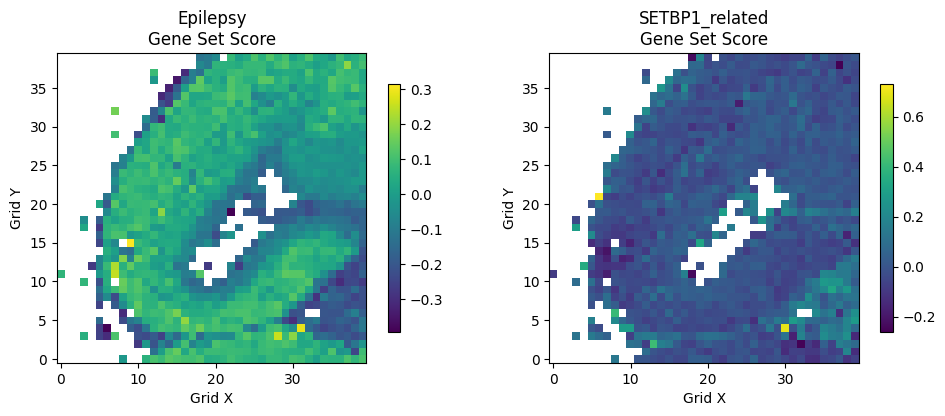

In [63]:
def plot_grid_scores(grid_scores, grid_size=(40, 40), save_dir=None):
    """
    Plot gene set scores as heatmaps on the spatial grid.
    """
    n_sets = len(grid_scores)
    if n_sets == 0:
        print("No gene sets to plot")
        return
    
    # Calculate subplot layout
    n_cols = min(3, n_sets)
    n_rows = (n_sets + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    
    # Handle different cases for axes indexing
    if n_sets == 1:
        axes = [axes]  # Single subplot case
    elif n_rows == 1:
        # Single row case - axes is already a 1D array
        pass
    else:
        # Multiple rows case - axes is already a 2D array
        pass
    
    for idx, (set_name, data) in enumerate(grid_scores.items()):
        row = idx // n_cols
        col = idx % n_cols
        
        # Get the correct axis based on the layout
        if n_sets == 1:
            ax = axes[0]
        elif n_rows == 1:
            ax = axes[col]
        else:
            ax = axes[row, col]
        
        # Reshape scores to grid
        score_grid = data['scores'].reshape(grid_size)
        
        # Create heatmap
        im = ax.imshow(score_grid, cmap='viridis', aspect='equal', origin='lower')
        ax.set_title(f'{set_name}\nGene Set Score')
        ax.set_xlabel('Grid X')
        ax.set_ylabel('Grid Y')
        
        # Add colorbar
        plt.colorbar(im, ax=ax, shrink=0.8)
    
    # Hide empty subplots
    for idx in range(n_sets, n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        
        # Get the correct axis for hiding
        if n_sets == 1:
            continue  # No empty subplots in single plot case
        elif n_rows == 1:
            ax = axes[col]
        else:
            ax = axes[row, col]
        ax.set_visible(False)
    
    plt.tight_layout()
    
    if save_dir:
        plt.savefig(os.path.join(save_dir, "spatial_gene_set_scores.png"), dpi=300, bbox_inches='tight')
        print(f"Saved spatial gene set scores plot to {save_dir}")
    
    plt.show()

# Plot results
plot_grid_scores(grid_scores, grid_size=(40, 40), save_dir=results_dir)

### Save Results

In [64]:
# Save grid scores to CSV
for set_name, data in grid_scores.items():
    # Create DataFrame with grid positions and scores
    df = pd.DataFrame({
        'grid_x': [pos[0] for pos in data['positions']],
        'grid_y': [pos[1] for pos in data['positions']],
        'score': data['scores']
    })
    
    # Save to CSV
    output_file = os.path.join(results_dir, f"grid_scores_{set_name}.csv")
    df.to_csv(output_file, index=False)
    print(f"Saved {set_name} grid scores to {output_file}")

# Save summary statistics
summary_stats = []
for set_name, data in grid_scores.items():
    scores = data['scores']
    valid_scores = scores[~np.isnan(scores)]
    
    if len(valid_scores) > 0:
        stats = {
            'gene_set': set_name,
            'n_grid_cells': len(valid_scores),
            'mean_score': np.mean(valid_scores),
            'std_score': np.std(valid_scores),
            'min_score': np.min(valid_scores),
            'max_score': np.max(valid_scores)
        }
        summary_stats.append(stats)

summary_df = pd.DataFrame(summary_stats)
summary_file = os.path.join(results_dir, "gene_set_scoring_summary.csv")
summary_df.to_csv(summary_file, index=False)
print(f"Saved summary statistics to {summary_file}")

print("\nSpatial gene set scoring analysis complete!")
print("Results saved in the 'analysis_results' directory:")
print("- spatial_gene_set_scores.png: Heatmap visualization")
print("- grid_scores_*.csv: Individual gene set scores per grid cell")
print("- gene_set_scoring_summary.csv: Summary statistics")

Saved Epilepsy grid scores to ./2task_cellpose2_p30-E165_R1_roi_analysis_parallel/analysis_results/grid_scores_Epilepsy.csv
Saved SETBP1_related grid scores to ./2task_cellpose2_p30-E165_R1_roi_analysis_parallel/analysis_results/grid_scores_SETBP1_related.csv
Saved summary statistics to ./2task_cellpose2_p30-E165_R1_roi_analysis_parallel/analysis_results/gene_set_scoring_summary.csv

Spatial gene set scoring analysis complete!
Results saved in the 'analysis_results' directory:
- spatial_gene_set_scores.png: Heatmap visualization
- grid_scores_*.csv: Individual gene set scores per grid cell
- gene_set_scoring_summary.csv: Summary statistics
